In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
!wget https://gist.github.com/mbejda/7f86ca901fe41bc14a63/archive/38adb475c14a3f44df9999c1541f3a72f472b30d.zip
!unzip 38adb475c14a3f44df9999c1541f3a72f472b30d.zip
import pandas as pd
file_path = '/content/7f86ca901fe41bc14a63-38adb475c14a3f44df9999c1541f3a72f472b30d/Indian-Male-Names.csv'
df = pd.read_csv(file_path)
names = df['name']
output_file = 'names.txt'
names.to_csv(output_file, index=False, header=False)

--2024-06-02 20:47:19--  https://gist.github.com/mbejda/7f86ca901fe41bc14a63/archive/38adb475c14a3f44df9999c1541f3a72f472b30d.zip
Resolving gist.github.com (gist.github.com)... 140.82.112.4
Connecting to gist.github.com (gist.github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/7f86ca901fe41bc14a63/zip/38adb475c14a3f44df9999c1541f3a72f472b30d [following]
--2024-06-02 20:47:19--  https://codeload.github.com/gist/7f86ca901fe41bc14a63/zip/38adb475c14a3f44df9999c1541f3a72f472b30d
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘38adb475c14a3f44df9999c1541f3a72f472b30d.zip’

38adb475c14a3f44df9     [ <=>                ]  68.09K  --.-KB/s    in 0.02s   

2024-06-02 20:47:19 (2.69 MB/s) - ‘38adb475c14a3f44d

In [4]:
# Formatting the data
alphabets = set("abcdefghijklmnopqrstuvwxyz")
words=open('names.txt','r').read().splitlines()
words = [name for name in words if all(char in alphabets for char in name.lower()) and ' ' not in name]
words[0]="samyak"
words = list(set(words))


In [5]:
len(words) #6429 without filtering

2198

In [6]:
# Building the vocabulary of characters and maping to/from integers
chars=sorted(list(set(''.join(words))))
stoi= {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
# Building the dataset
block_size=3
def build_dataset(words):

  X,Y=[],[]

  for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w+ '.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context),'--->', itos[ix])
      context=context[1:]+[ix]
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

In [8]:
# Dataset
Xtr.shape, Ytr.shape,Xdev.shape, Ydev.shape,Xte.shape, Yte.shape

(torch.Size([13403, 3]),
 torch.Size([13403]),
 torch.Size([1713, 3]),
 torch.Size([1713]),
 torch.Size([1689, 3]),
 torch.Size([1689]))

In [9]:
# Hyperparameter for the model
embedding_input=2
emb_input=block_size*embedding_input
neurons=6
outputs=27
# ----

g=torch.Generator().manual_seed(19)
C=torch.randn((outputs,embedding_input),generator=g)
W1=torch.randn((emb_input,neurons)     ,generator=g) * (5/3)/(emb_input**0.5)
b1=torch.randn(neurons                 ,generator=g) *0
W2=torch.randn((neurons,outputs)       ,generator=g) *0.01
b2=torch.randn(outputs                 ,generator=g) *0

bngain=torch.ones((1,neurons))
bnbias=torch.zeros((1,neurons))
bnmean_running=torch.zeros((1,neurons))
bnstd_running=torch.ones((1,neurons))

parameters=[C,W1,b1,W2,b2,bngain,bnbias]
total_elements=0
for p in parameters:
    total_elements += p.nelement()

print(total_elements)
for p in parameters:
  p.requires_grad=True

297


In [10]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [11]:
# Hyperparameters
lri=[]
stepi=[]
lossi=[]
batch_size=16
max_steps=30000
lrs_e=[0.1,0.01]

for lr in lrs_e:
  for i in range(max_steps if lr==0.1 else 1000):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))

    # Forward pass
    emb=C[Xtr[ix]]
    hpreact=emb.view(-1,emb_input) @ W1 +b1
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*((hpreact-bnmeani)/bnstdi)+bnbias

    with torch.no_grad():
      bnmean_running=0.999*bnmean_running+0.001*bnmeani
      bnstd_running=0.999*bnmean_running+0.001*bnstdi

    h=torch.tanh(hpreact)
    logits=h @W2 +b2
    loss=F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())

    # Backward pass
    for p in parameters:
      p.grad=None
    loss.backward()

    # Update
    # lr=lrs[i]
    lr=0.1
    for p in parameters:
      p.data+= -lr*p.grad

    # Track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    # break
  print(loss.item())


2.0157322883605957
2.39292049407959


In [12]:
@torch.no_grad()
def split_loss(split):
  x,y={
      'train':{Xtr,Ytr},
      'val':{Xdev,Ydev},
      'test':{Xte,Yte},
  }[split]
  emb=C[x]
  hpreact=emb.view(-1,emb_input) @ W1 +b1
  hpreact=bngain*((hpreact-bnmeani)/bnstdi)+bnbias
  h=torch.tanh(hpreact)
  logits=h @ W2+b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.371025323867798
val 2.4098803997039795
test 2.3823604583740234


In [13]:
# loss log

# orig
# train 2.163638381958008
# val 2.1569042205810547

# softmax
# train 2.133638381958008
# val 2.1569042205810547

# tanh
# train 2.0898821353912354
# val 2.0876331329345703

# initializing changes
# train 2.0980582237243652
# val 2.101440668106079

# batch norm
# train 2.057295083999634
# val 2.196613073348999

# reducing the params by a lot
# train 2.345360040664673
# val 2.357156753540039
# test 2.397008180618286

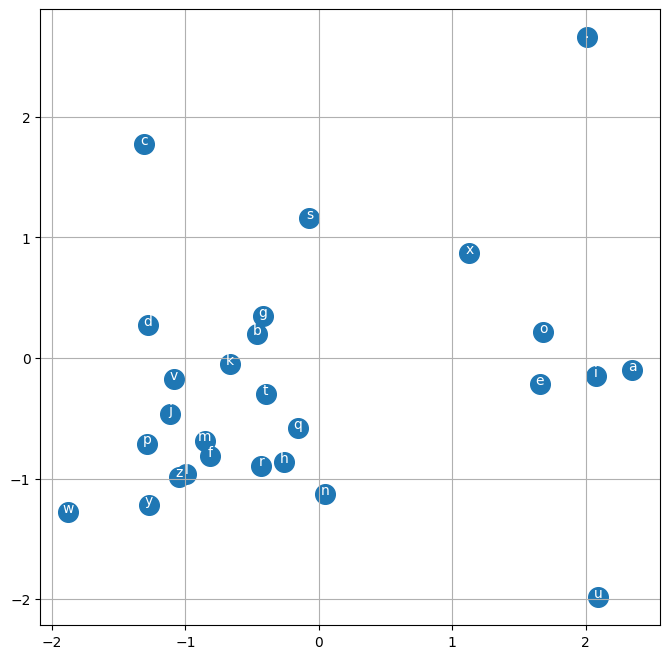

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",color="white")
  plt.grid('minor')

In [15]:
# plt.figure(figsize=(5,5))
# plt.imshow(h.abs()>0.99,cmap="gray",interpolation="nearest")

In [16]:
# plt.hist(h.view(-1).tolist(),bins=50);

In [17]:
# plt.hist(hpreact.view(-1).tolist(),bins=50);

In [18]:
# # plt.plot(lri,lossi)
# plt.plot(stepi,lossi)

In [19]:
# Sample from the model
g=torch.Generator().manual_seed(19)

for _ in range(20):
  out=[]
  context=[0]* block_size
  while True:
    emb=C[torch.tensor([context])]
    hpreact=emb.view(-1,emb_input) @ W1 +b1
    hpreact=bngain*((hpreact-bnmeani)/bnstdi)+bnbias
    h=torch.tanh(hpreact)
    logits=h @ W2+b2
    probs=F.softmax(logits,dim=1)
    ix=torch.multinomial(probs, num_samples=1, generator=g).item()
    context=context[1:]+[ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

shajitn.
meghaddnaratv.
puranjzi.
yanw.
kutash.
rilbajsh.
ilt.
pur.
malsonbn.
akmash.
logimin.
shash.
johh.
vrisghpai.
kufdir.
jas.
boler.
coes.
hinan.
rumdaniun.


In [196]:
#  Creating the lib

class Linear:

  def __init__(self,fan_in,fan_out,bias=True):
    self.weight=torch.randn((fan_in,fan_out), generator=g) #/ fan_in**0.5
    self.bias=torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out=x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight]+ ([] if self.bias is None else [self.bias])

class BatchNormId:

  def __init__(self,dim,eps=1e-5,momentum=0.1):
    # parameters
    self.eps=eps
    self.training=True
    self.momentum=momentum
    # buffers
    self.gamma        = torch.ones(dim)
    self.beta         = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var  = torch.ones(dim)

  def __call__(self,x):
    if self.training is True:
      xmean= x.mean(0,keepdim=True)
      xvar=x.var(0,keepdim=True)
    else:
      xmean=self.running_mean
      x_var=self.running_var
    xhat=(x-xmean)/torch.sqrt(xvar+self.eps)
    self.out= self.gamma*xhat+self.beta
    # Update the buffers
    if self.training is True:
      with torch.no_grad():
        self.running_mean= (1-self.momentum)*self.running_mean+self.momentum * xmean
        self.running_var = (1-self.momentum)*self.running_var+self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__(self,x):
    self.out=torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [197]:
vocab_size=27
n_embed=3
n_hidden=6
g=torch.Generator().manual_seed(19)

C=torch.randn((vocab_size,n_embed),   generator=g)

layers=[
    Linear(n_embed*block_size,n_hidden),BatchNormId(n_hidden),Tanh(),
    # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
    # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
    # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
    # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
    Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
    Linear(          n_hidden,vocab_size),BatchNormId(vocab_size),
]
# layers=[
#     Linear(n_embed*block_size,n_hidden),Tanh(),
#     # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
#     # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
#     # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
#     # Linear(          n_hidden,n_hidden),BatchNormId(n_hidden),Tanh(),
#     Linear(          n_hidden,n_hidden),Tanh(),
#     Linear(          n_hidden,vocab_size),
# ]

with torch.no_grad():
  layers[-1].gamma*=0.1
  # layers[-1].weight*=0.1
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight*= 1 #5/3

parameters=[C]+[p for layer in layers for p in layer.parameters()]
param=0
for p in parameters:
  param+=p.nelement()
  p.requires_grad=True
print(param)

450


In [198]:
# Hyperparameters
lri=[]
stepi=[]
lossi=[]
batch_size=16
max_steps=30000
lrs_e=[0.1,0.01]
ud=[]

for i in range(max_steps if lr==0.1 else 1000):
  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb=Xtr[ix],Ytr[ix]

  # Forward pass
  emb=C[Xb]
  x=emb.view(emb.shape[0],-1)
  for layer in layers:
    x=layer(x)
  loss=F.cross_entropy(x,Yb)
  # print(loss.item())

  # Backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad=None
  loss.backward()

  # Update
  # lr=lrs[i]
  lr=0.1
  for p in parameters:
    p.data+= -lr*p.grad

  # Track stats
  # lri.append(lre[i])
  if i % 10000==0:
    print(f'{1:7d}/{max_steps:7d}:{loss.item():.4f}')
  stepi.append(i)
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
  # if i >=1000:
  #   break
print(loss.item())


      1/  30000:3.2733
      1/  30000:2.6364
      1/  30000:2.5040
2.7782835960388184


layer 2 (      Tanh): mean +0.15, std 0.61, saturated: 6.25%
layer 5 (      Tanh): mean +0.15, std 0.54, saturated: 3.12%


Text(0.5, 1.0, 'activation distribution')

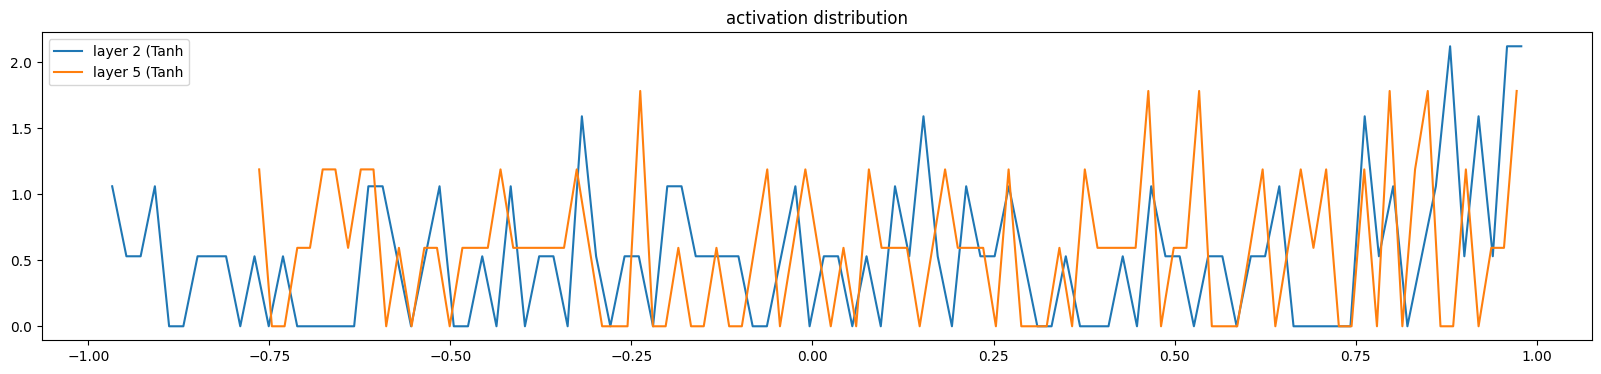

In [199]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.244693e-02
layer 5 (      Tanh): mean -0.000000, std 6.103947e-02


Text(0.5, 1.0, 'gradient distribution')

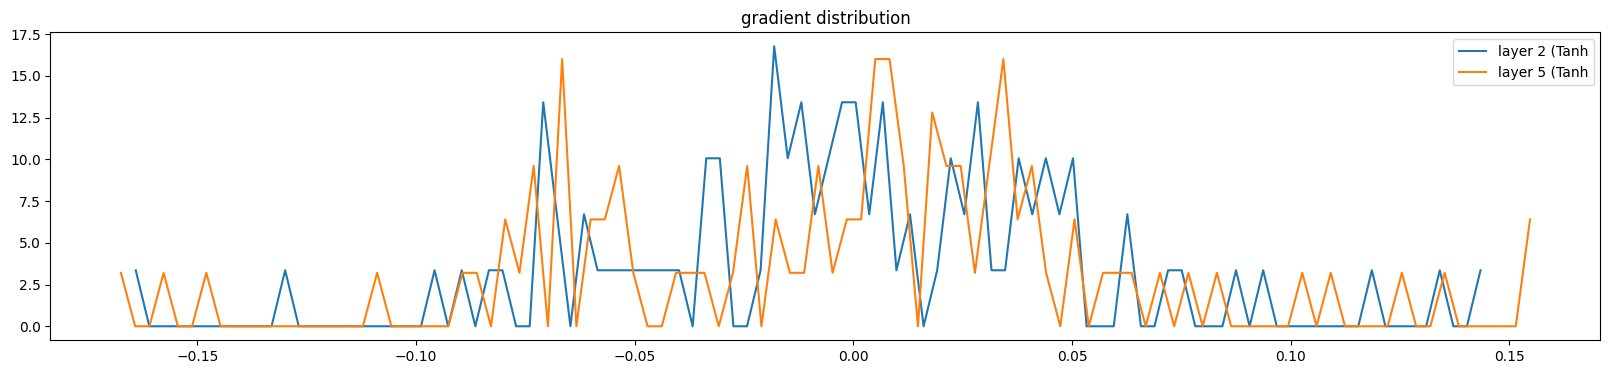

In [200]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight    (27, 3) | mean -0.000000 | std 2.910537e-02 | grad:data ratio 2.756608e-02
weight     (9, 6) | mean -0.000322 | std 2.939114e-02 | grad:data ratio 2.543836e-02
weight     (6, 6) | mean +0.015525 | std 3.594540e-02 | grad:data ratio 3.025801e-02
weight    (6, 27) | mean -0.000354 | std 2.296890e-02 | grad:data ratio 2.177160e-02


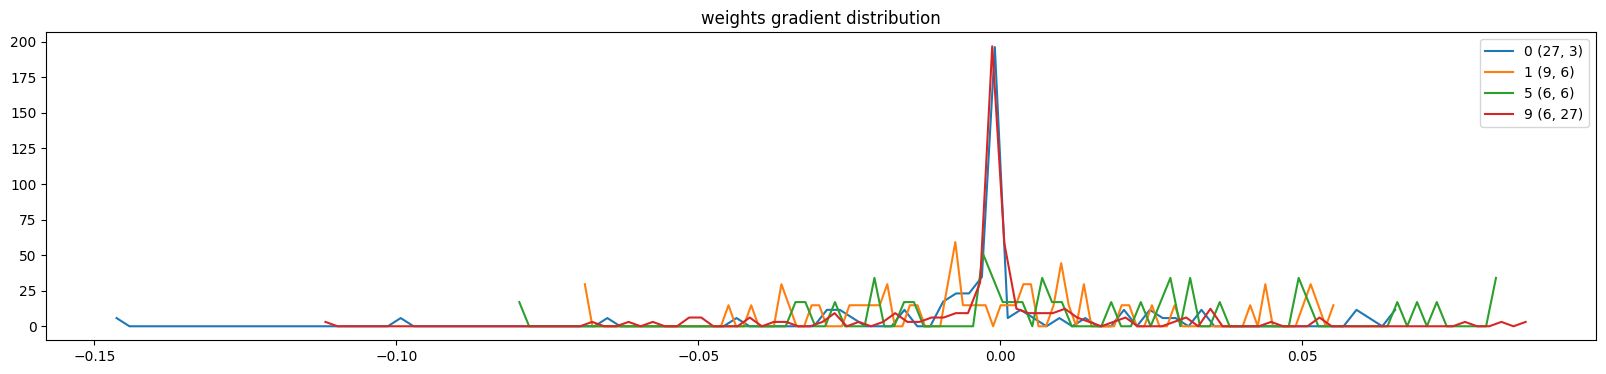

In [201]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

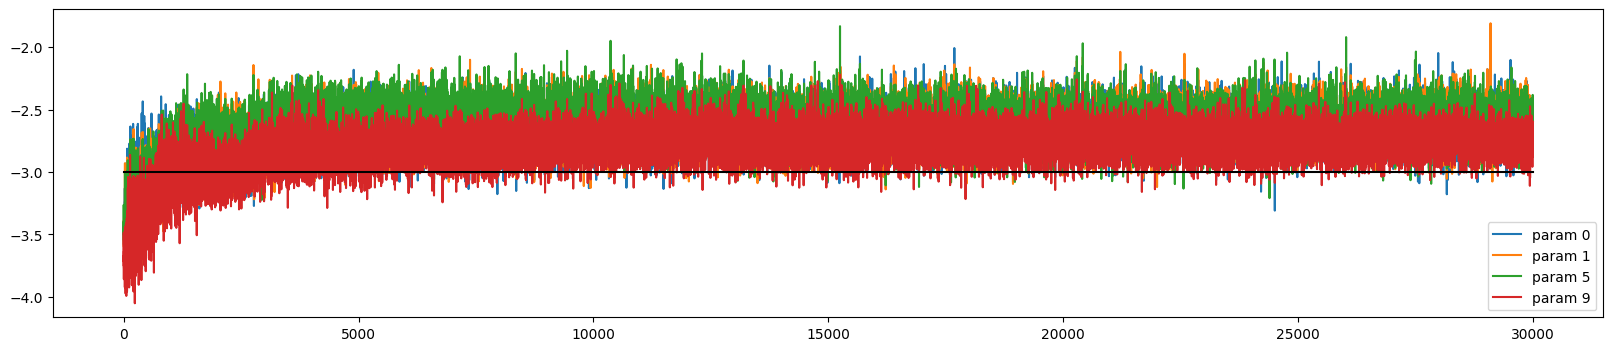

In [202]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [203]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[X]
    x = emb.view(emb.shape[0], -1)

    # Pass through the first Linear layer, BatchNormId, and Tanh
    hpreact = layers[0](x)
    hpreact = layers[1](hpreact)
    h = layers[2](hpreact)

    # Pass through the second Linear layer, BatchNormId, and Tanh
    hpreact = layers[3](h)
    hpreact = layers[4](hpreact)
    h = layers[5](hpreact)

    # Pass through the final Linear layer
    logits = layers[6](h)

    # Apply the final BatchNormId layer
    logits = layers[7](logits)

    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 2.2881782054901123
val 2.327176570892334
test 2.313988208770752


In [ ]:
# loss log

# orig
# train 2.163638381958008
# val 2.1569042205810547

# softmax
# train 2.133638381958008
# val 2.1569042205810547

# tanh
# train 2.0898821353912354
# val 2.0876331329345703

# initializing changes
# train 2.0980582237243652
# val 2.101440668106079

# batch norm
# train 2.057295083999634
# val 2.196613073348999

# reducing the params by a lot
# train 2.345360040664673
# val 2.357156753540039
# test 2.397008180618286

# mlp2
# train 2.2881782054901123
# val 2.327176570892334
# test 2.313988208770752

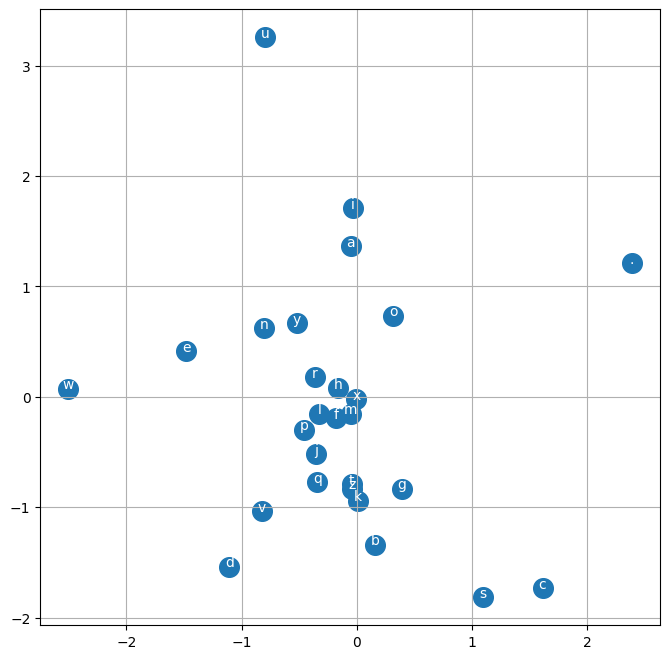

In [204]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",color="white")
  plt.grid('minor')